In [1]:
lidar_128_path = '/home/luca/Desktop/projects/get_dataset_from_carla/datasets/0_29_10_2024_12:14:05_Town10HD/lidar_32/0.npz'
K_path = '/home/luca/Desktop/projects/get_dataset_from_carla/datasets/0_29_10_2024_12:14:05_Town10HD/K_camera.txt'
rgb_path = '/home/luca/Desktop/projects/get_dataset_from_carla/datasets/0_29_10_2024_12:14:05_Town10HD/rgb_0/0.jpg'
semantic_path = '/home/luca/Desktop/projects/get_dataset_from_carla/datasets/0_29_10_2024_12:14:05_Town10HD/semantic_0/0.png'
depth_path = '/home/luca/Desktop/projects/get_dataset_from_carla/datasets/0_29_10_2024_12:14:05_Town10HD/depth_0/0.png'
normal_path = '/home/luca/Desktop/projects/get_dataset_from_carla/datasets/0_29_10_2024_12:14:05_Town10HD/normals_0/0.png'

import numpy as np
import matplotlib.pyplot as plt
import cv2
import open3d as o3d
from cityscape_color_pallet import pallet_cityscape
from matplotlib.colors import ListedColormap

lidar_128 = np.load(lidar_128_path)
K = np.loadtxt(K_path)

RT_cam_lidar = np.array([[0,1,0],[0,0,-1],[1,0,0]]) # Y
# RT_cam_lidar = np.eye(3)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import numpy as np

def array_to_ply(points, filename="output.ply"):
    """
    Converts an Nx3 numpy array to a PLY file.

    Parameters:
        points (np.ndarray): An Nx3 numpy array where each row is a point (x, y, z).
        filename (str): The name of the output PLY file.
    """
    if points.shape[1] != 3:
        raise ValueError("Input array must have shape Nx3.")

    # Define the PLY header
    header = f"""ply
format ascii 1.0
element vertex {points.shape[0]}
property float x
property float y
property float z
end_header
"""

    # Save the PLY file
    with open(filename, 'w') as ply_file:
        ply_file.write(header)
        for point in points:
            ply_file.write(f"{point[0]} {point[1]} {point[2]}\n")

    print(f"PLY file saved as {filename}")

# Example usage:
# points = np.array([[0, 0, 0], [1, 1, 1], [2, 2, 2]])
# array_to_ply(points, "output.ply")


array_to_ply(lidar_128['lidar_data_raw'][:,:3], 'lidar.ply')

PLY file saved as lidar.ply


In [3]:
print(K)

[[512.   0. 512.]
 [  0. 512. 128.]
 [  0.   0.   1.]]


In [4]:
for key in lidar_128.keys():
    print(key)

lidar_data_raw


In [5]:
lidar_128['lidar_data_raw'][0,:3]

array([ -3.0416992, -26.049683 ,  15.758576 ], dtype=float32)

In [6]:
pcd = (RT_cam_lidar @ lidar_128['lidar_data_raw'][:,:3].T).T
print(pcd.shape)

(27576, 3)


In [7]:
def get_view(L0_points, rotomtx, K, D, height, width, z_limit = 100, camera_fov = 64):

    if isinstance(L0_points, np.ndarray):
        L0_cloud = o3d.geometry.PointCloud()
        L0_cloud.points = o3d.utility.Vector3dVector(L0_points)
    else:
        L0_cloud = L0_points

    Cn_cloud = L0_cloud.transform(rotomtx)

    
    camera_fov = camera_fov/180*np.pi # The ec FoV is 62, but we are taking a bit more
    xy_limit = z_limit * np.tan(camera_fov/2)

    bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=(-xy_limit, -xy_limit, 0.05),
                                               max_bound=(xy_limit, xy_limit, z_limit))
    Cn_cloud_crop = Cn_cloud.crop(bbox)

    diameter = np.linalg.norm(np.array(Cn_cloud_crop.get_max_bound()) -
                              np.array(Cn_cloud_crop.get_min_bound()))
    
    # https://github.com/isl-org/Open3D/blob/ff22900c958d0216c85305ee8b3841e5699f9d57/examples/python/geometry/point_cloud_hidden_point_removal.py#L24C4-L24C4
    hpr_radius = diameter * 100
    if hpr_radius > 0 and len(Cn_cloud_crop.points) > 4:
        _, pt_map = Cn_cloud_crop.hidden_point_removal(np.zeros((3,)), hpr_radius)
        Cn_cloud_HPR = Cn_cloud_crop.select_by_index(pt_map)


        camera_points = np.array(Cn_cloud_HPR.points)

        rvecs = np.zeros((3,1)) # cv2.Rodrigues(np.eye(3))[0]
        tvecs = np.zeros((3,1))

        imgpts, _ = cv2.projectPoints(camera_points, rvecs, tvecs, K, D)

        imgpts = imgpts[:,0,:]
        valid_points = (imgpts[:, 1] >= 0) & (imgpts[:, 1] < height) & \
                    (imgpts[:, 0] >= 0) & (imgpts[:, 0] < width)
        imgpts = imgpts[valid_points,:]
        depth = camera_points[valid_points,2]


        image = np.zeros([height, width]) + np.inf
        image[imgpts[:,1].astype(int), imgpts[:,0].astype(int)] = depth

        image[ image==0.0 ] = np.inf

        return image

    return np.zeros([height, width]) + np.inf


In [8]:
bgr = cv2.imread(rgb_path)
H, W, _ = bgr.shape

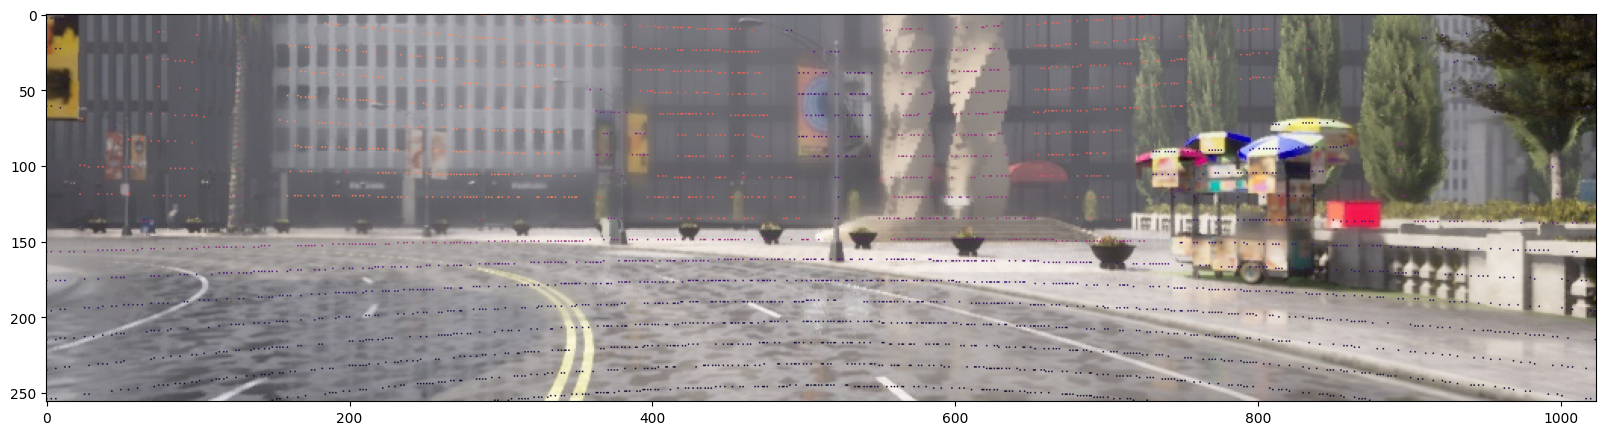

In [9]:
lidar_img = get_view(pcd, np.eye(4), K, np.zeros(5), H, W, z_limit = 100, camera_fov = 90)
lidar_img[lidar_img == np.inf] = 0

lidar_img_colormap = cv2.applyColorMap((lidar_img/100*255).astype(np.uint8), cv2.COLORMAP_MAGMA)
bgr_lidar_img = bgr.copy()
bgr_lidar_img[lidar_img != 0] = lidar_img_colormap[lidar_img != 0]

plt.figure(figsize=(20,15))
plt.imshow(cv2.cvtColor(bgr_lidar_img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
cv2.imwrite('test.png', (lidar_img*256.0).astype(np.uint16))

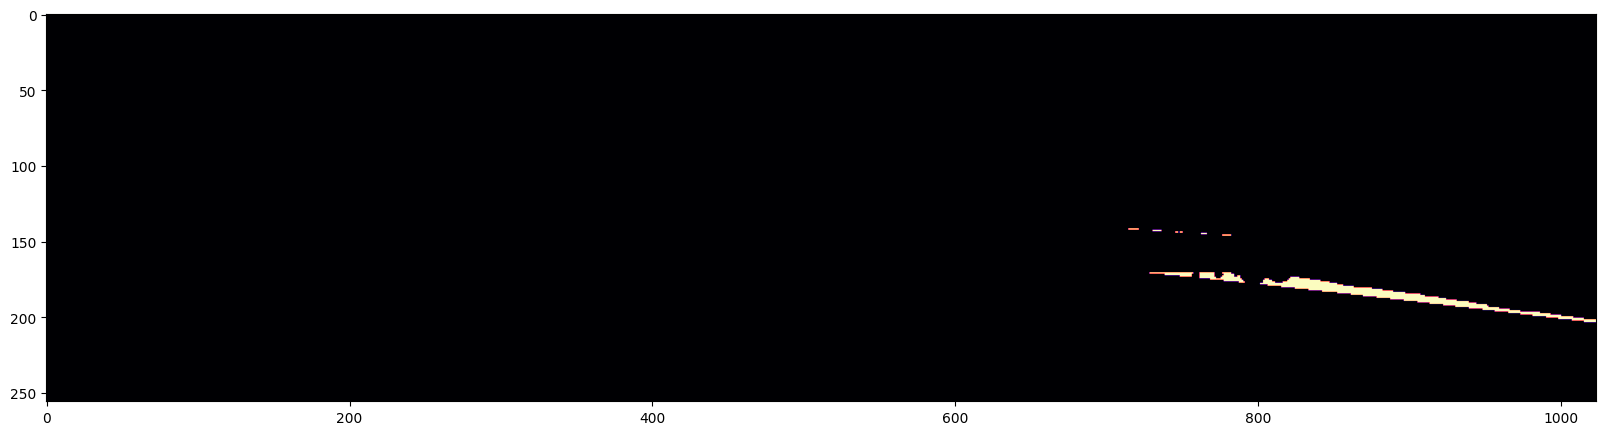

In [40]:
semantic = cv2.imread(semantic_path)
semantic = cv2.cvtColor(semantic, cv2.COLOR_BGR2RGB)
semantic = semantic[:, :, 0]
semantic_one = semantic.copy()
semantic_one[semantic_one != 10] = 0

my_cmap = ListedColormap(pallet_cityscape[0])

plt.figure(figsize=(20,15))
# plt.imshow(semantic, cmap=my_cmap)
plt.imshow(semantic_one, cmap='magma')
plt.show()

In [11]:
# intensity calculation
lut_reflectivity = {
    0: 1.0, # Unlabelled
    1: 0.5, # Roads
    2: 0.5, # Sidewalks
    3: 0.5, # Buildings
    4: 0.5, # Walls
    5: 0.5, # Fences
    6: 0.7, # Poles
    7: 0.7, # Traffic lights
    8: 1.0, # Traffic signs
    9: 0.5, # Vegetation
    10: 0.5, # Terrain
    11: 0.0, # Sky
    12: 0.6, # Persons
    13: 0.6, # Riders
    14: 0.8, # Cars
    15: 0.8, # Trucks
    16: 0.8, # Buses
    17: 0.8, # Trains
    18: 0.8, # Motorcycles
    19: 0.8, # Bicycles
    20: 0.5, # Static
    21: 0.5, # Dynamic
    22: 0.5, # Other
    23: 0.1, # Water
    24: 1.0, # Roads lines
    25: 0.5, # Ground
    26: 0.5, # Bridge
    27: 0.8, # Rail track
    28: 0.8, # Guard rail
}



In [12]:
depth = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH) / 65535.0 * 1000.0

In [13]:
print((depth.min(), depth.max()))

(7.400625619897764, 162.37125200274664)


14.984359502555886


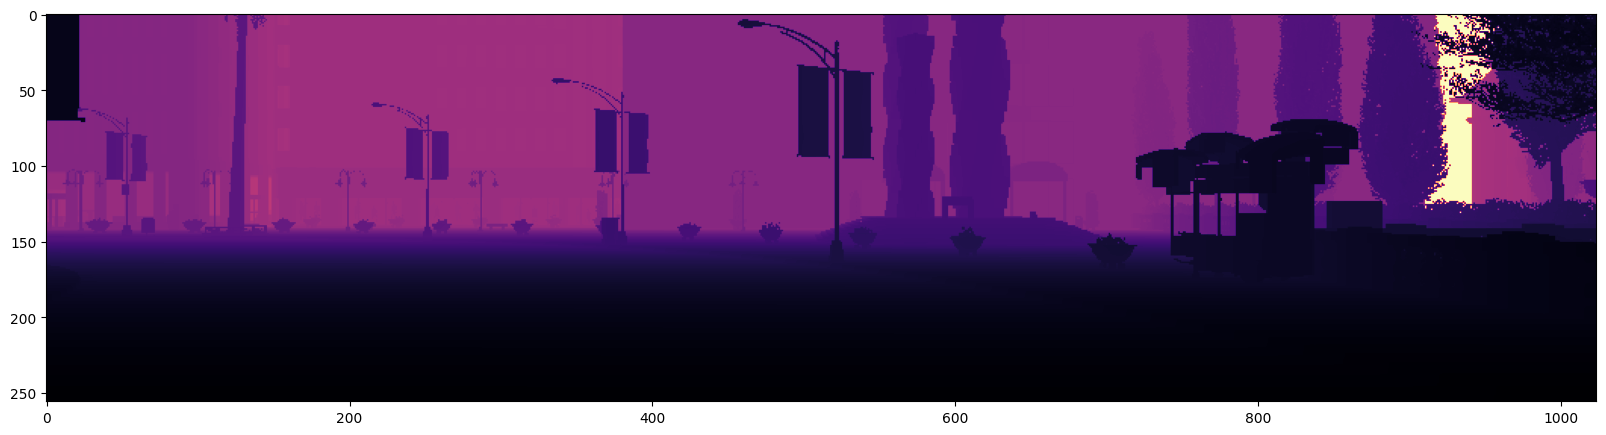

In [55]:
print(depth[0,0])
plt.figure(figsize=(20,15))
plt.imshow(depth, cmap='magma')
plt.show()

(256, 1024, 3)


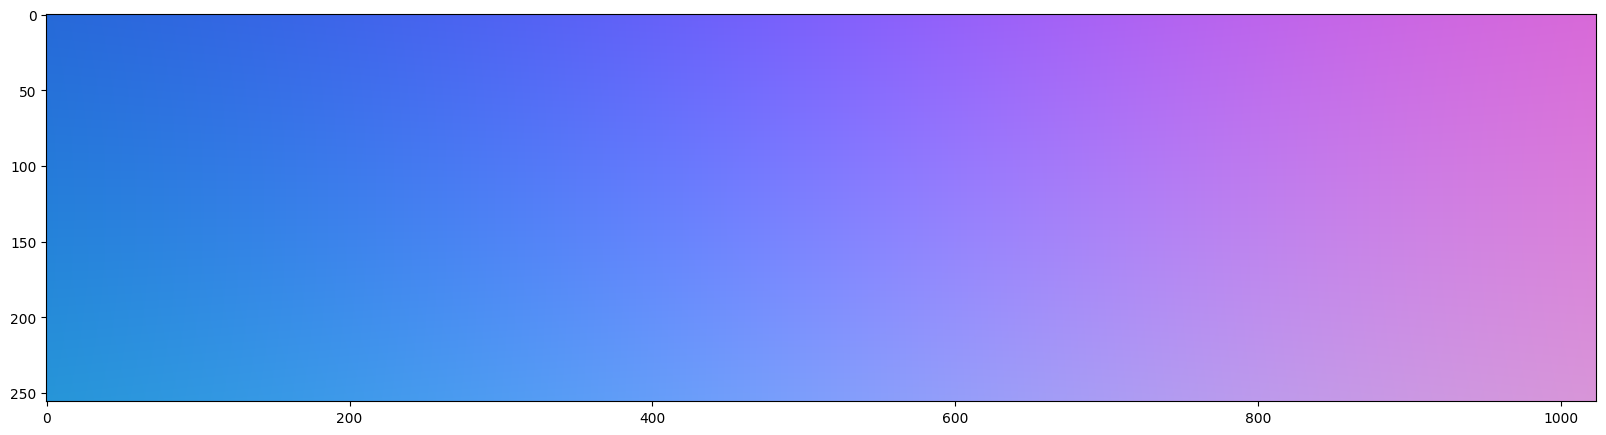

In [15]:

def depth_to_rays(depth_map, camera_matrix):
    """
    Converts a HxW depth map to a HxWx3 rays map.
    
    Parameters:
        depth_map (np.ndarray): HxW depth map where each pixel value is the depth.
        camera_matrix (np.ndarray): 3x3 camera intrinsic matrix.

    Returns:
        rays_map (np.ndarray): HxWx3 rays map where each ray is a vector from the optical center to the 3D point.
    """
    H, W = depth_map.shape
    rays_map = np.zeros((H, W, 3), dtype=np.float32)
    
    # Camera intrinsic parameters
    fx = camera_matrix[0, 0]
    fy = camera_matrix[1, 1]
    cx = camera_matrix[0, 2]
    cy = camera_matrix[1, 2]

    # Create a grid of pixel coordinates
    y_coords, x_coords = np.indices((H, W))

    # Project each pixel into 3D space in the camera frame
    X = (x_coords - cx) * depth_map / fx
    Y = (y_coords - cy) * depth_map / fy
    Z = depth_map

    # Combine the coordinates into a HxWx3 array of 3D points
    points_3d = np.stack((X, Y, Z), axis=-1)

    # Calculate rays as vectors from the optical center to each 3D point
    # Normalize each vector to get direction
    norms = np.linalg.norm(points_3d, axis=2, keepdims=True)
    rays_map = points_3d / norms  # Normalize each ray vector

    return rays_map

# Example usage
# depth_map = np.random.rand(480, 640) * 10  # Example depth map in meters
# camera_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
# rays_map = depth_to_rays(depth_map, camera_matrix)

rays_map = depth_to_rays(depth, K)
print(rays_map.shape)

plt.figure(figsize=(20,15))
plt.imshow((rays_map + 1) / 2)
plt.show()

[ 0.         0.        14.9843595  1.       ]
[7.57084001e+03 1.88715953e+03 7.40062562e+00 1.00000000e+00]
[-14.9843595   -3.74608988  14.9843595 ]
[7.38617127 1.83570206 7.40062562]
(256, 1024, 3)


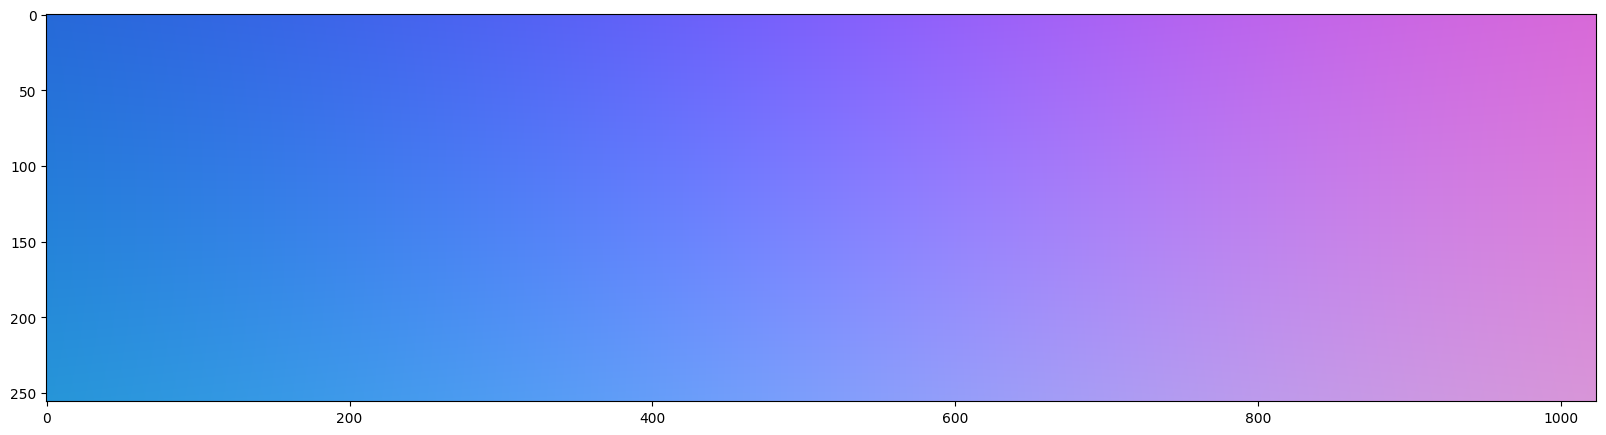

In [16]:

def depth_to_rays_v2(depth_map, camera_matrix):
    """
    Converts a HxW depth map to a HxWx3 rays map.
    
    Parameters:
        depth_map (np.ndarray): HxW depth map where each pixel value is the depth.
        camera_matrix (np.ndarray): 3x3 camera intrinsic matrix.

    Returns:
        rays_map (np.ndarray): HxWx3 rays map where each ray is a vector from the optical center to the 3D point.
    """
    H, W = depth_map.shape
    rays_map = np.zeros((H, W, 3), dtype=np.float32)
    
    P = np.eye(4)
    P[:3,:3] = camera_matrix
    P_inv = np.linalg.inv(P)

    # Create a grid of pixel coordinates
    y_coords, x_coords = np.indices((H, W))

    # Project each pixel into 3D space in the camera frame
    X = x_coords * depth_map
    Y = y_coords * depth_map
    Z = depth_map

    # Combine the coordinates into a HxWx3 array of 3D points
    points_3d = np.stack((X, Y, Z, np.ones_like(Z)), axis=-1)

    print(points_3d[0,0])
    print(points_3d[-1,-1])

    # Calculate rays as vectors from the optical center to each 3D point
    # Normalize each vector to get direction
    points_3d = points_3d.reshape(-1, 4)
    points_3d = np.dot(P_inv, points_3d.T).T
    points_3d = points_3d[:,:3].reshape(H, W, 3)

    print(points_3d[0,0])
    print(points_3d[-1,-1])

    norms = np.linalg.norm(points_3d, axis=2, keepdims=True)
    rays_map = points_3d / norms  # Normalize each ray vector

    return rays_map

# Example usage
# depth_map = np.random.rand(480, 640) * 10  # Example depth map in meters
# camera_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
# rays_map = depth_to_rays(depth_map, camera_matrix)

rays_map = depth_to_rays_v2(depth, K)
print(rays_map.shape)

plt.figure(figsize=(20,15))
plt.imshow((rays_map + 1) / 2)
plt.show()

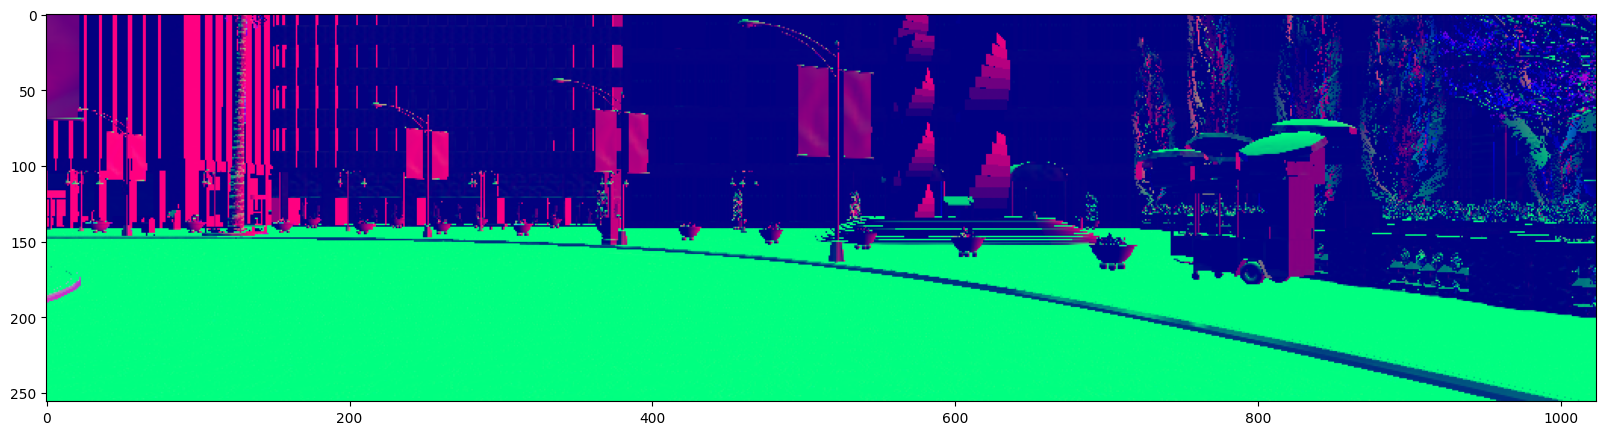

In [17]:
normal = cv2.imread(normal_path)
normal = cv2.cvtColor(normal, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,15))
plt.imshow(normal)
plt.show()

normal = normal / 255.0 * 2.0 - 1.0
normal = normal / np.linalg.norm(normal, axis=2, keepdims=True)

(0.14619901002639274, 0.9886751416066352)


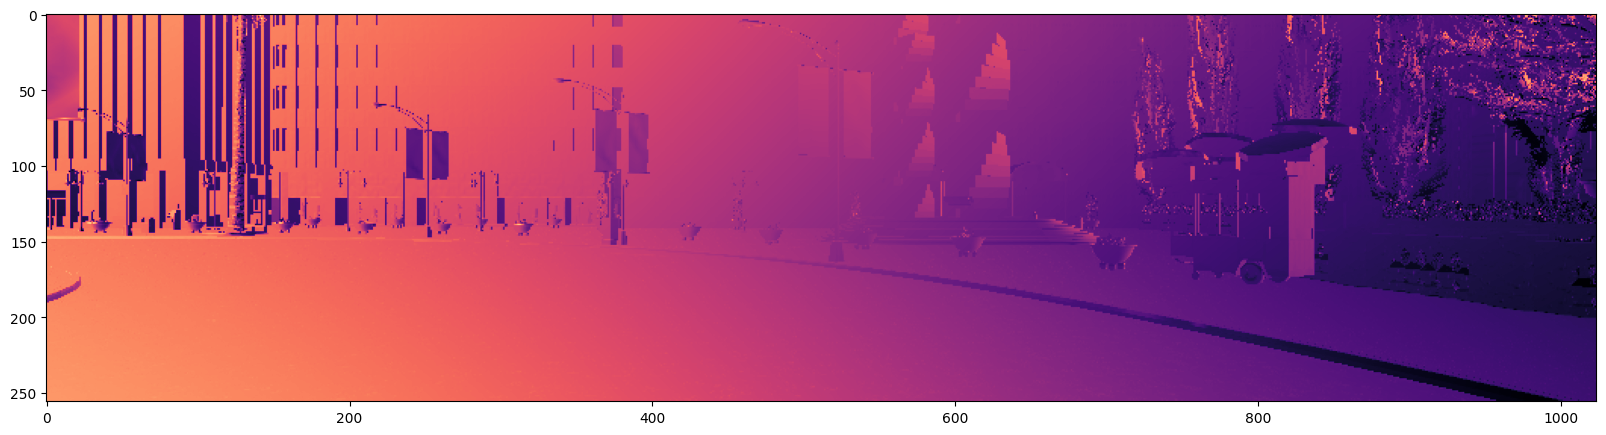

In [52]:
incident_map = np.sum(normal * rays_map, axis=2)
incident_map = (incident_map + 1) / 2
# incident_map = np.arccos(incident_map)
# incident_map = np.cos(incident_map)
incident_map[np.isinf(incident_map)] = 0
# incident_map = np.abs(incident_map)

print((incident_map.min(), incident_map.max()))

plt.figure(figsize=(20,15))
plt.imshow(incident_map, cmap='magma')
plt.show()

In [93]:
# RT_normal = np.array([[1,0,0], [0,-1,0], [0,0,-1]])

# new_normal_map = RT_normal @ normal.reshape(-1,3).T
# new_normal_map = new_normal_map.T.reshape(normal.shape)

# # incident_map_a = -np.clip(np.sum(new_normal_map * rays_map, axis=2), -1, 0)
# # incident_map_b = np.clip(np.sum(new_normal_map * rays_map, axis=2), 0, 1)
# # incident_map = (incident_map_a + incident_map_b) / 2

# incident_map = np.arccos(np.sum(new_normal_map * rays_map, axis=2))
# incident_map[np.isnan(incident_map)] = 0
# incident_map = np.clip(incident_map, 0, np.pi)
# incident_map = np.cos(incident_map)

# plt.figure(figsize=(20,15))
# plt.imshow(incident_map, cmap='magma')
# plt.show()

(0.0, 1.0)


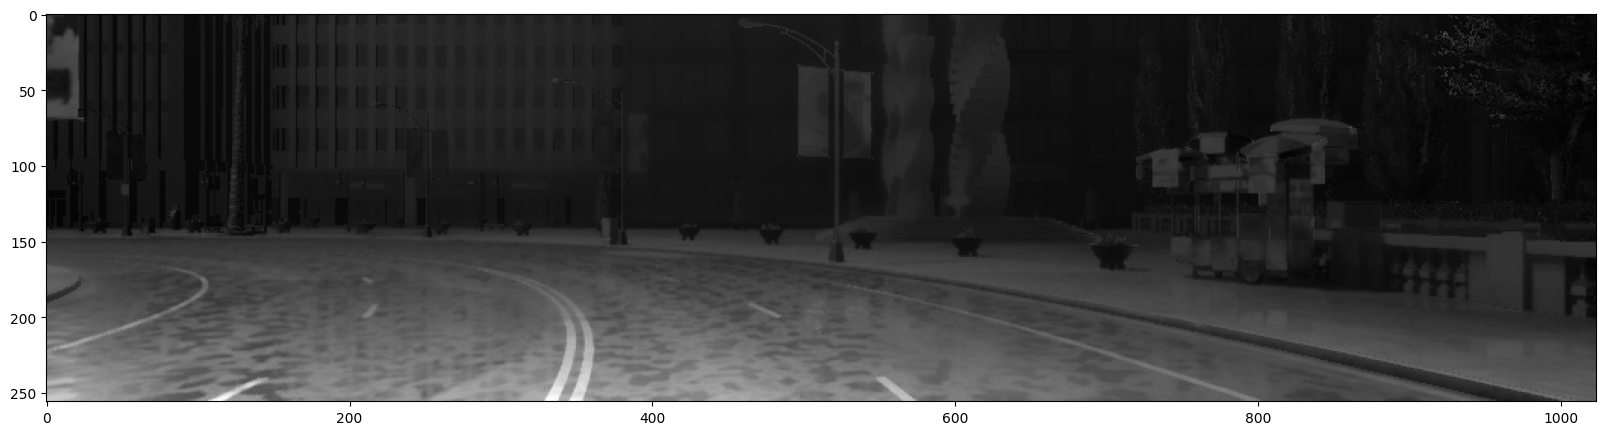

In [84]:
gray_scale = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY) / 255.0
log_depth = np.log(depth)
attenuation_gain = 1

# intensity_map = np.zeros_like(depth, dtype=np.float32)
# intensity_map[depth<=10] = gray_scale[depth<=10] * incident_map[depth<=10] / (attenuation_gain * 10 * log_depth[depth<=10])
# intensity_map[depth>10] = gray_scale[depth>10] * incident_map[depth>10] / (attenuation_gain * log_depth[depth>10]) ** 2

intensity_map = gray_scale * incident_map / (attenuation_gain * log_depth) ** 2

intensity_map = (intensity_map - intensity_map.min()) / (intensity_map.max() - intensity_map.min())

print((intensity_map.min(), intensity_map.max()))

# semantic_one = semantic.copy()
# semantic_one[semantic_one != 11] = 0
# intensity_map[semantic_one>0] = 0

plt.figure(figsize=(20,15))
plt.imshow(intensity_map, cmap='gray')
plt.show()

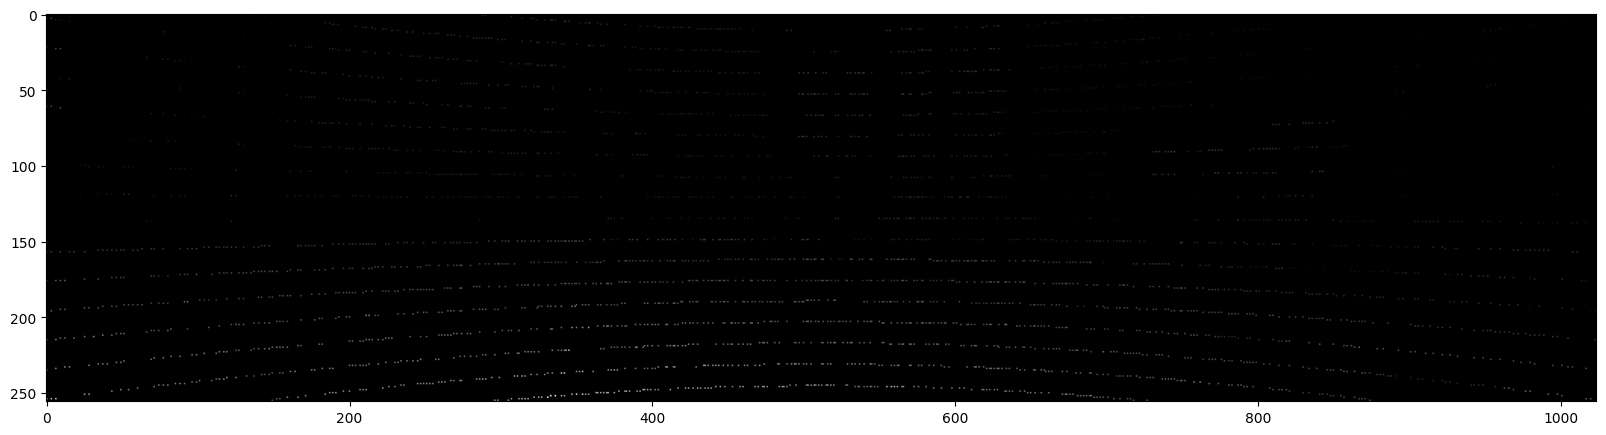

In [85]:
intensity_map_masked = intensity_map.copy()
intensity_map_masked[lidar_img<=0] = 0

plt.figure(figsize=(20,15))
plt.imshow(intensity_map_masked, cmap='gray')
plt.show()

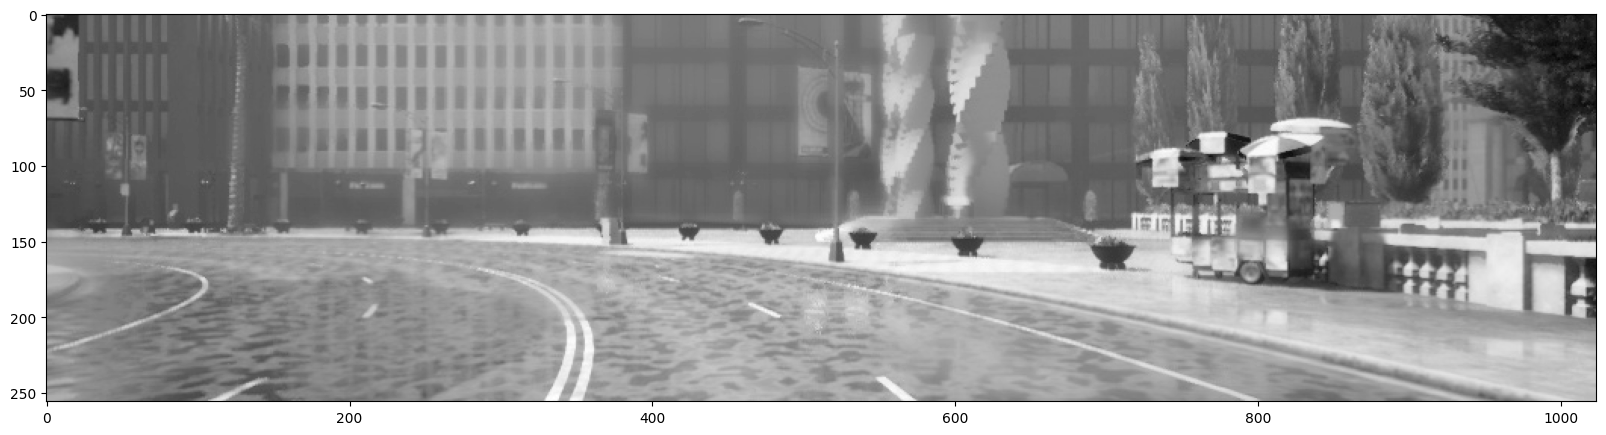

In [76]:
plt.figure(figsize=(20,15))
plt.imshow(gray_scale, cmap='gray')
plt.show()